<h1> Image Classification using VGG-like Architecture</h1>

In our everyday life, image classification helps us in taking important decisions. It is important to divide the data in particular class or group based on their attributes corresponding to objects. In past years reserachers have explored advanced techniques of classification to enhance accuracy. One such example is the VGG16 Model that reduced the error rate to 7.3%. 
Here a VGG-like architecture, customized based on experiments. 


In [30]:
# necessary imports
import tensorflow as tf
from sklearn.datasets import load_files
import numpy as np
import os
import cv2
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import collections
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
import keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, f1_score
from skimage import feature
from skimage import exposure
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
%matplotlib inline

<h2> Load Dataset </h2>
Here we will download the Dataset of Natural Scene from kaggel intel-image-classification and unzip it in local colab directory <br><br>


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamna27","key":"9944f09a800fd209ebde42468fb6f834"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 334M/346M [00:03<00:00, 129MB/s]
100% 346M/346M [00:03<00:00, 109MB/s]


In [ ]:
!unzip intel-image-classification.zip -d Dataset
!rm -rf /content/intel-image-classification.zip

In [7]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (32, 32))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [8]:
train_dir = "Dataset/seg_train/seg_train"
val_dir = "Dataset/seg_test/seg_test"
test_dir = "Dataset/seg_pred/seg_pred"

In [ ]:
!rm -rf /content/Dataset/seg_pred
!unzip Test_data.zip -d Dataset

In [11]:
print('loading train images')
X_train, y_train = load_data(train_dir)
print('loading test images')
X_val, y_val = load_data(val_dir)
print('loading test images')
X_test, y_test = load_data(test_dir)


  9%|▉         | 194/2191 [00:00<00:01, 1931.35it/s]

loading train images


 47%|████▋     | 204/437 [00:00<00:00, 2032.24it/s]

loading test images


 18%|█▊        | 201/1144 [00:00<00:00, 2006.50it/s]

loading test images


100%|██████████| 1236/1236 [00:00<00:00, 2001.58it/s]


Binarize labels in a one-vs-all fashion for train, valiadation and test data


In [12]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

Making dictionary to store results of experiments

In [13]:
all_acc_dict = collections.OrderedDict()
accdict = {}

<h2> VGG-Like Architecture </h2>
Architecture build on VGG style is being used here. Since original architecture was very complex, few layers have been removed based on problem at hand. Instead of 224*224*3, input shape of 32*32*3 has been used.

In [15]:
def VGG16model(OPTIMIZER, DECAY, MOMEMTUM, LEARN_RATE, EPOCHS, INPUT_SHAPE_WIDTH = 32, 
               INPUT_SHAPE_HEIGHT = 32, INPUT_SHAPE_CHANNEL = 3):
  model = Sequential()
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", 
                  input_shape=(INPUT_SHAPE_WIDTH,INPUT_SHAPE_HEIGHT,INPUT_SHAPE_CHANNEL),))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=6, activation="softmax"))

  if OPTIMIZER == "Adam":
    print(OPTIMIZER)
    LEARN_RATE = LEARN_RATE/EPOCHS 
    adam = Adam(lr=LEARN_RATE)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)

  if OPTIMIZER == "SGD":
    print(OPTIMIZER)
    LEARN_RATE = LEARN_RATE/EPOCHS 
    sgd = SGD(lr=LEARN_RATE)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)

  if OPTIMIZER == "RMS":
    print(OPTIMIZER)
    LEARN_RATE = LEARN_RATE/EPOCHS 
    rms = RMSprop(lr=LEARN_RATE, decay=DECAY, momentum=MOMEMTUM)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=rms)
  return (model)

Adam


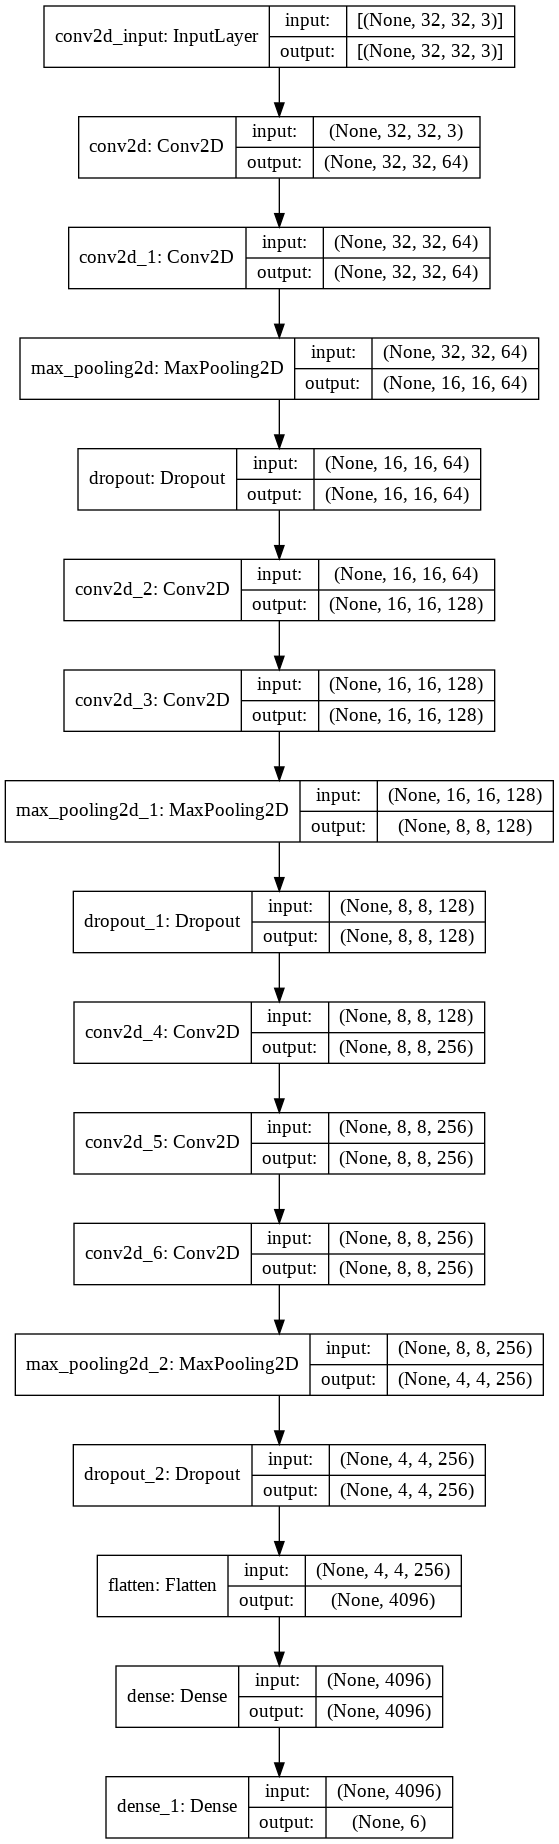

In [18]:

vgg_model_pic = VGG16model("Adam", DECAY= 1e-7, MOMEMTUM = 0.9, LEARN_RATE =0.001, EPOCHS =75)
plot_model(vgg_model_pic, to_file='VGG-like-model.png', show_shapes=True)

<h2> Compile and Train the Model </h2>
Using different choices of optimizers, the model is being trained. **Early Stopping** is being used to tackle number of epochs. Each time a better validation accuracy is achieved the model weights are updated in the directory.

In [19]:

es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('CheckPoints/VGG-like-model-weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def training(BATCH_SIZE, EPOCHS, OPTIMIZER, LEARN_RATE, DECAY = 0, MOMEMTUM = 0 ):
  accdict = {}
  vgg_model = VGG16model(OPTIMIZER, DECAY, MOMEMTUM, LEARN_RATE, EPOCHS)
  H = vgg_model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, callbacks=[es,mc])
  trainacc = H.history['accuracy']
  valacc = H.history['val_accuracy']
  trainloss = H.history['loss']
  valloss = H.history['val_loss']
  test_loss, test_acc = vgg_model.evaluate(X_test, y_test, verbose=0)
  accdict["trainacc"] =trainacc[len(trainacc)-1]
  accdict["trainloss"] =trainloss[len(trainloss)-1]
  accdict["valacc"] = valacc[len(valacc)-1]
  accdict["valloss"] = valloss[len(valloss)-1]
  accdict["testacc"] = test_acc
  accdict["testloss"] = test_loss
  
  return H, accdict

Experimentation including various batch sizes optimizers and learning rates are done.

In [20]:

History1, all_acc_dict["Adam_Exp1"] = training(32, 75, "Adam", 0.001)
History2, all_acc_dict["Adam_Exp2"] = training(64, 75, "Adam", 0.001)
History3, all_acc_dict["Adam_Exp3"] = training(128, 75,"Adam", 0.001) 


History4, all_acc_dict["SGD_Exp1"] = training(32, 75, "SGD", 0.001)
History5, all_acc_dict["SGD_Exp2"] = training(64, 75, "SGD", 0.001)
History6, all_acc_dict["SGD_Exp3"] = training(128, 75,"SGD", 0.001) 

History7, all_acc_dict["RMS_Exp1"] = training(32, 75, "RMS", 0.001)
History8, all_acc_dict["RMS_Exp2"] = training(64, 75, "RMS", 0.001)
History9, all_acc_dict["RMS_Exp3"] = training(128, 75,"RMS", 0.001) 

Adam
Epoch 1/75
439/439 [==============================] - 14s 15ms/step - loss: 1.7460 - accuracy: 0.2283 - val_loss: 1.3353 - val_accuracy: 0.4683

Epoch 00001: val_accuracy improved from -inf to 0.46833, saving model to CheckPoints/VGG-like-model-weights.h5
Epoch 2/75
439/439 [==============================] - 6s 14ms/step - loss: 1.2649 - accuracy: 0.5127 - val_loss: 1.2227 - val_accuracy: 0.5100

Epoch 00002: val_accuracy improved from 0.46833 to 0.51000, saving model to CheckPoints/VGG-like-model-weights.h5
Epoch 3/75
439/439 [==============================] - 6s 14ms/step - loss: 1.1341 - accuracy: 0.5499 - val_loss: 1.1436 - val_accuracy: 0.5543

Epoch 00003: val_accuracy improved from 0.51000 to 0.55433, saving model to CheckPoints/VGG-like-model-weights.h5
Epoch 4/75
439/439 [==============================] - 6s 14ms/step - loss: 1.0565 - accuracy: 0.5815 - val_loss: 1.0836 - val_accuracy: 0.5773

Epoch 00004: val_accuracy improved from 0.55433 to 0.57733, saving model to Che

<h2> Evaluate the Model </h2>
Model is evaluated on the weights that produced the highest validation accuracy. These weights were stored during training.


In [61]:

saved_model = load_model('CheckPoints/best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f,Val: %.3f, Test: %.3f' % (train_acc, val_acc,  test_acc))

Train: 0.881,Val: 0.805, Test: 0.801


<h2> Plotting Training and Validation accuracy of different optimizers </h2>

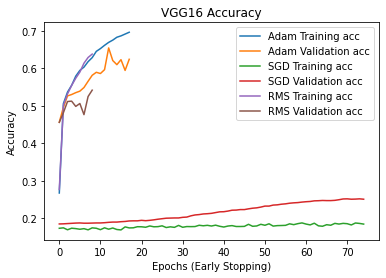

In [21]:

History = History2
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy')

plt.plot(epochs, acc, label='Adam Training acc')
plt.plot(epochs, val_acc, label='Adam Validation acc')

History =0
History = History4
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='SGD Training acc')
plt.plot(epochs, val_acc, label='SGD Validation acc')



History =0
History = History7
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='RMS Training acc')
plt.plot(epochs, val_acc, label='RMS Validation acc')
plt.legend()
plt.savefig("Results/SimpleVGG16Historyacc.png")



<h2> Plotting Training and Validation losses of different optimizers </h2>

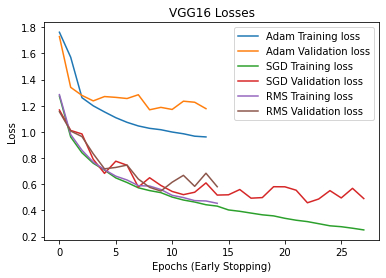

In [26]:

from sklearn.metrics import classification_report
%matplotlib inline
# print("[INFO] evaluating network...")
# predictions = model.predict(X_val, batch_size=32)
# print(classification_report(y_val.argmax(axis=1),
# 	predictions.argmax(axis=1), target_names=lb.classes_))
History =0
History = History3
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(loss))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Loss')
plt.title('VGG16 Losses')

plt.plot(epochs, loss, label='Adam Training loss')
plt.plot(epochs, val_loss, label='Adam Validation loss')

History =0
History = History5
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='SGD Training loss')
plt.plot(epochs, val_loss, label='SGD Validation loss')



History =0
History = History7
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='RMS Training loss')
plt.plot(epochs, val_loss, label='RMS Validation loss')
plt.legend()
plt.savefig("Results/SimpleVGG16Historyloss.png")



Printing accuracies and losses of experiments


In [25]:

for k, v in all_acc_dict.items():
    trainacc, trainloss, valacc, valloss,testacc, testloss = v
    print(v)
    print( "".format(k, trainacc, trainloss, valacc, valloss,testacc, testloss ))

Key      Label           Number    
{'trainacc': 0.7439789175987244, 'trainloss': 0.6914740204811096, 'valacc': 0.6966666579246521, 'valloss': 0.8468077182769775, 'testacc': 0.7014107704162598, 'testloss': 0.8455212712287903}

{'trainacc': 0.7077098488807678, 'trainloss': 0.77986079454422, 'valacc': 0.6056666374206543, 'valloss': 1.0881507396697998, 'testacc': 0.6067662239074707, 'testloss': 1.0914565324783325}

{'trainacc': 0.6338891386985779, 'trainloss': 0.9611303806304932, 'valacc': 0.5493333339691162, 'valloss': 1.1771454811096191, 'testacc': 0.536912739276886, 'testloss': 1.176484227180481}

{'trainacc': 0.8869887590408325, 'trainloss': 0.30421072244644165, 'valacc': 0.8433333039283752, 'valloss': 0.47630536556243896, 'testacc': 0.8361868262290955, 'testloss': 0.5166838765144348}

{'trainacc': 0.9071540832519531, 'trainloss': 0.25053802132606506, 'valacc': 0.8410000205039978, 'valloss': 0.490104615688324, 'testacc': 0.8361868262290955, 'testloss': 0.539230227470398}

{'trainacc':

<h2> Predict on Unseen Images </h2>


In [43]:

saved_model = load_model('CheckPoints/VGG-like-model-weights.h5')
predY = saved_model.predict(X_test)

Test Label: 0
Predicted Label: 0


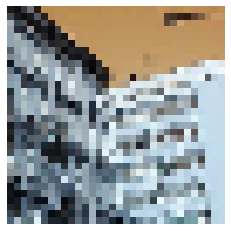

Test Label: 1
Predicted Label: 1


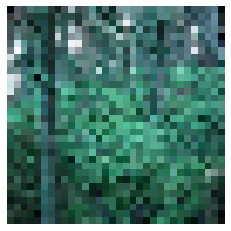

Test Label: 0
Predicted Label: 0


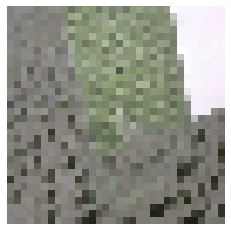

Test Label: 2
Predicted Label: 2


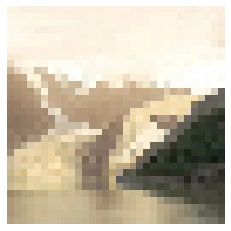

Test Label: 5
Predicted Label: 5


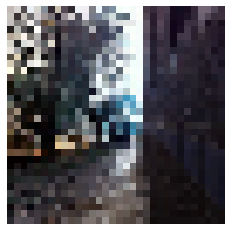

In [54]:
random = [1000, 5000, 50, 2000, len(X_test)-10]
for index in random:
 #load test image
 image = X_test[index]
 # Compare and visualize
 figr, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
 ax1.axis('off')
 ax1.imshow(image)
 test_label = y_test.argmax(1)
 pred_label = predY.argmax(1)
 print('Test Label: {}'.format(test_label[index]))
 print('Predicted Label: {}'.format(pred_label[index]))
 plt.show()
 figr.savefig("Results/VisualzingResults"+str(index)+".jpg")

<h2> Confusion Matrix </h2>

In [55]:
#Confusion Matrix
actual = pd.Series(y_test.ravel(),name='Actual')
predicted = pd.Series(predY.ravel(),name='Predicted')
predY_classes = predY.argmax(1)
y_test_classes = y_test.argmax(1)
confusion_matrix = pd.crosstab(y_test_classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0     0     1     2     3    4     5   All
row_0                                         
0       696   159    44    66   34   145  1144
1         7  1123     3     5    2    26  1166
2        94    16   889   206   95    30  1330
3        58     8   135   920  170     6  1297
4        65     9   141   230  671    12  1128
5       111   248    20    29   18   810  1236
All    1031  1563  1232  1456  990  1029  7301


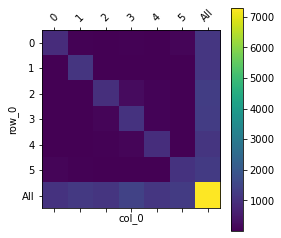

In [32]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)
  plt.savefig("SimpleVGG16confusion.jpg")
#call function
plot_confusion_matrix(confusion_matrix)

In [56]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive
